# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектутру нейромережі представлено на наступному малюнку. Як бачите, у ній є один вхідний шар, два прихованих, а також вихідний шар. Як активаційну функцію в прихованих шарах буде використовуватися сигмоїда. На вихідному шарі ми використовуємо softmax.

Частину коду зі створення мережі вже написано, від вас вимагається заповнити пропуски в зазначених місцях.

## Архитектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Цю нейромережу ми будемо навчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше датасет буде поділено на навчальну і тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів перебували в проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Крім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [27]:
num_classes = 10  # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784  # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001  # швидкість навчання нейронної мережі
training_steps = 3000  # максимальне число епох
batch_size = 256  # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100  # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару

In [28]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор із 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape(
    [-1, num_features]
)

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255, x_test / 255.0

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [29]:
# Створимо нейронну мережу


class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation):
        y = tf.matmul(x, self.w) + self.b
        if activation == "relu":
            return tf.nn.sigmoid(y)
        elif activation == "softmax":
            return tf.nn.softmax(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, що складається зі 128 нейронів
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

        # Другий шар, що складається з 256 нейронів
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

        # Вихідний шар
        self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        x = self.layer_1(x, "relu")
        x = self.layer_2(x, "relu")

        # Пам'ятайте що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
        # Робимо ми це для того, щоб
        # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
        # належності вхідного об'єкта до одного з 10 класів

        x = self.out_layer(x, "softmax")
        return x

In [30]:
# Як функцію помилки в цьому випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Кодуємо мітки в one hot вектор.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Кліпуємо значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворення ймовірностей у класи (індекси з максимальною ймовірністю)
    predicted_classes = tf.argmax(y_pred, 1)
    # Підрахунок збігів зі справжніми класами
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, dtype=tf.int64))
    # Обчислення точності
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

    return accuracy

In [31]:
# Створимо екзампляр нейронної мережі
neural_net = NN(name="mnist")


# Функція навчання нейромережі
def train(nn, input_x, output_y):
    # Для підгонки ваг мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.Adam(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = nn(input_x)
        loss = cross_entropy(pred, output_y)

        # Створимо список параметрів, що оптимізуються
        trainable_variables = nn.trainable_variables

        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [32]:
# Тренування мережі
# кожні display_step кроків зберігайте в цьому списку поточну помилку нейромережі
loss_history = []
# кожні display_step кроків зберігайте в цьому списку поточну точність нейромережі
accuracy_history = []
steps = []

# У цьому циклі ми будемо проводити навчання нейронної мережі
# з тренувального датасету train_data витягніть випадкову підмножину, на якій
# відбудеться тренування. Використовуйте метод take, доступний для тренувального датасету.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        steps.append(step)
        print(
            f"Крок: {step}, Помилка: {current_loss:>7.1f}, Точність: {current_accuracy:.2f}"
        )

Крок: 100, Помилка:   752.5, Точність: 0.66
Крок: 200, Помилка:   606.8, Точність: 0.74
Крок: 300, Помилка:   561.6, Точність: 0.79
Крок: 400, Помилка:   481.4, Точність: 0.81
Крок: 500, Помилка:   202.7, Точність: 0.80
Крок: 600, Помилка:   118.2, Точність: 0.86
Крок: 700, Помилка:   103.8, Точність: 0.92
Крок: 800, Помилка:    95.3, Точність: 0.89
Крок: 900, Помилка:   108.9, Точність: 0.91
Крок: 1000, Помилка:    57.6, Точність: 0.94
Крок: 1100, Помилка:   105.0, Точність: 0.92
Крок: 1200, Помилка:    68.9, Точність: 0.93
Крок: 1300, Помилка:    82.1, Точність: 0.92
Крок: 1400, Помилка:    55.6, Точність: 0.95
Крок: 1500, Помилка:    74.5, Точність: 0.92
Крок: 1600, Помилка:    59.5, Точність: 0.95
Крок: 1700, Помилка:    52.0, Точність: 0.93
Крок: 1800, Помилка:    34.0, Точність: 0.96
Крок: 1900, Помилка:    58.9, Точність: 0.94
Крок: 2000, Помилка:    33.9, Точність: 0.97
Крок: 2100, Помилка:    33.0, Точність: 0.96
Крок: 2200, Помилка:    41.5, Точність: 0.95
Крок: 2300, Помилка

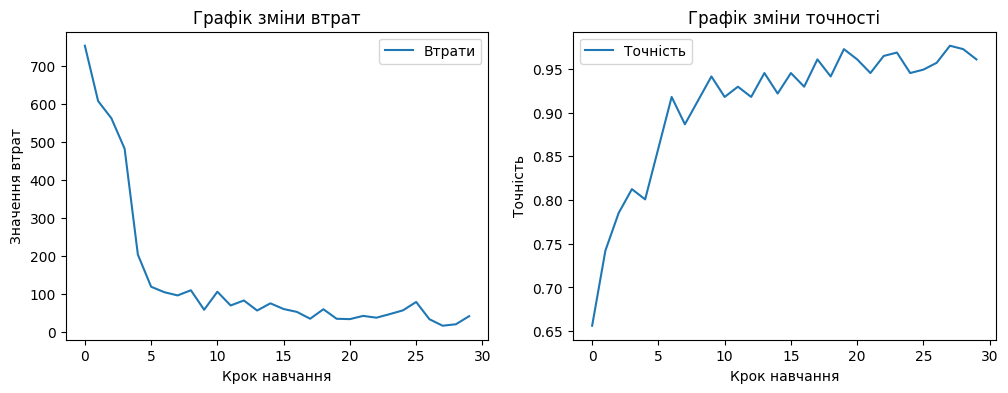

In [33]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure(figsize=(12, 4))

# Графік зміни втрат
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Втрати")
plt.title("Графік зміни втрат")
plt.xlabel("Крок навчання")
plt.ylabel("Значення втрат")
plt.legend()

# Графік зміни точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Точність")
plt.title("Графік зміни точності")
plt.xlabel("Крок навчання")
plt.ylabel("Точність")
plt.legend()

plt.show()

In [59]:
# обчисліть точність навченої нейромережі

# Загрузка тестового датасету
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)

# Функція для визначення точності
def evaluate_accuracy(model, test_data):
    accuracy = tf.keras.metrics.Accuracy()
    
    for batch_x, batch_y in test_data:
        predictions = model(batch_x)
        predicted_classes = tf.argmax(predictions, axis=1)
        accuracy.update_state(batch_y, predicted_classes)
    
    return accuracy.result().numpy()

# Оцінка точності
test_accuracy = evaluate_accuracy(neural_net, test_data)
print(f"Точність на тестовому датасеті: {test_accuracy}")

Точність на тестовому датасеті: 0.9347000122070312


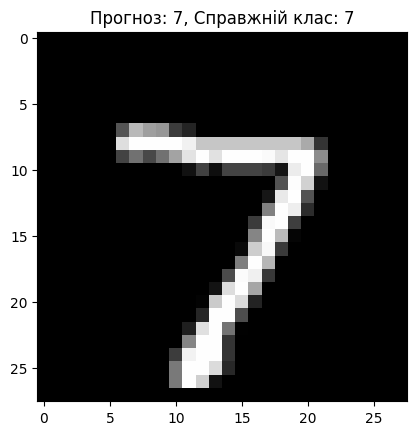

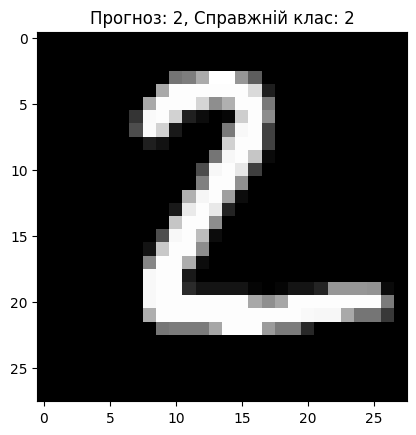

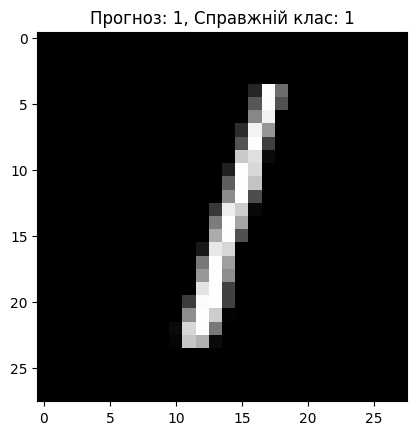

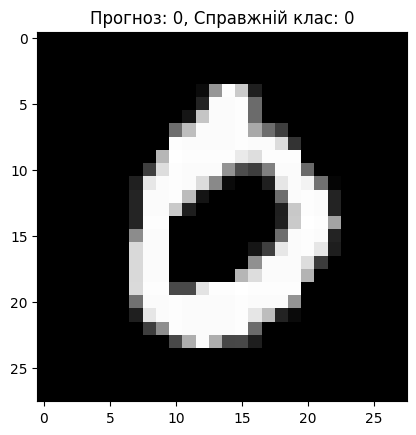

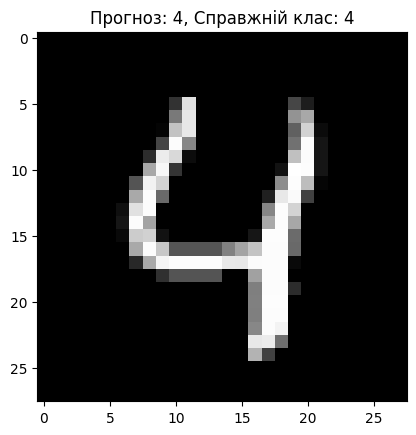

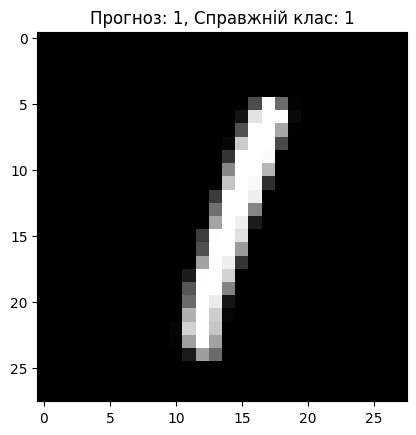

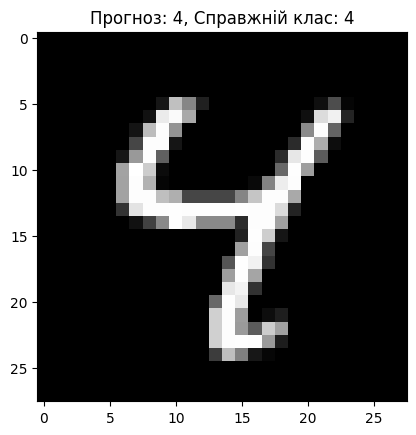

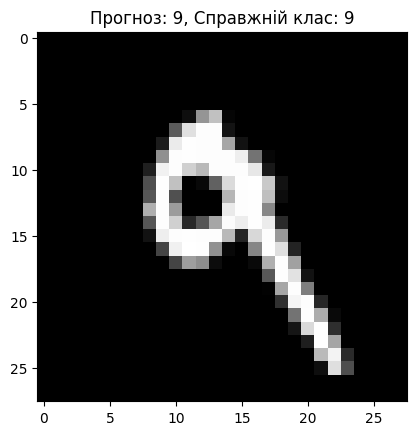

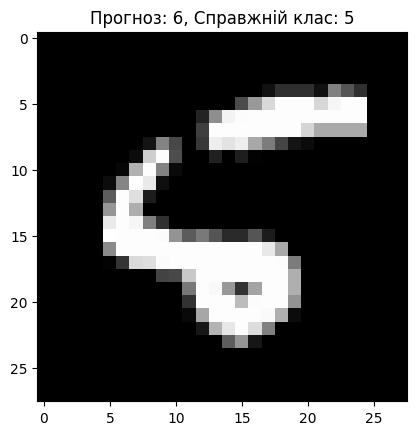

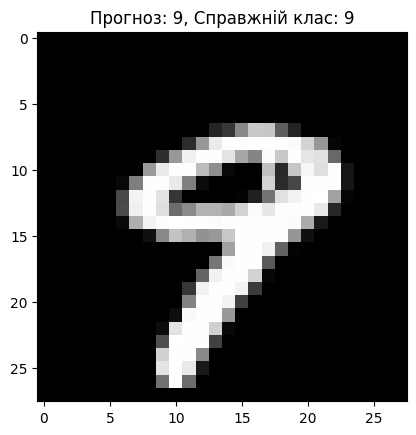

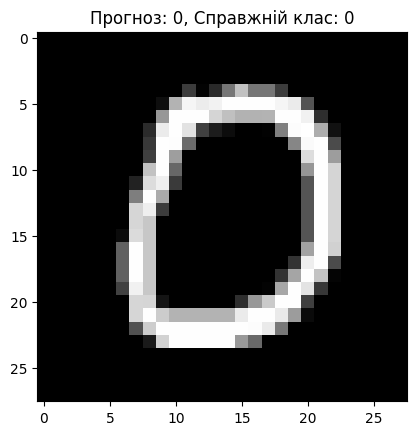

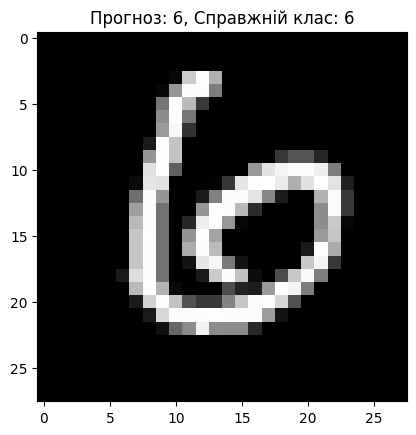

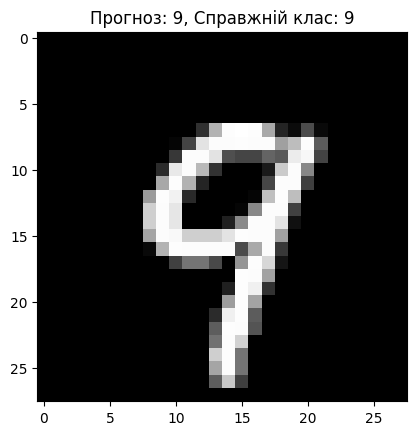

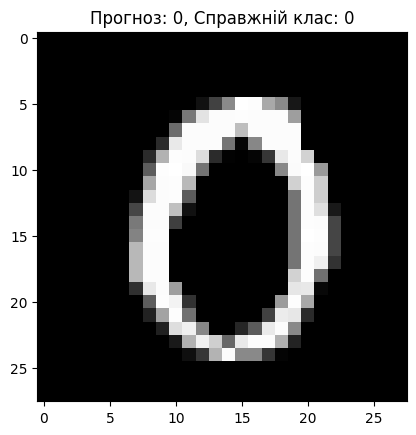

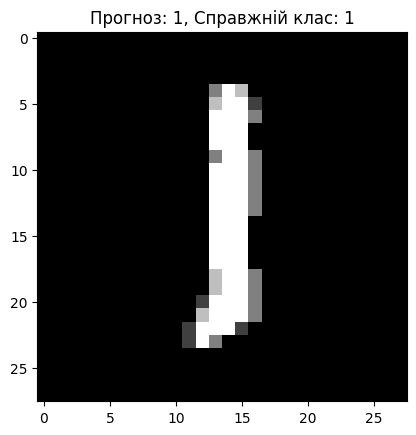

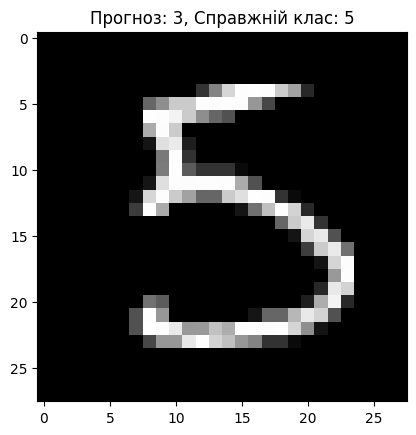

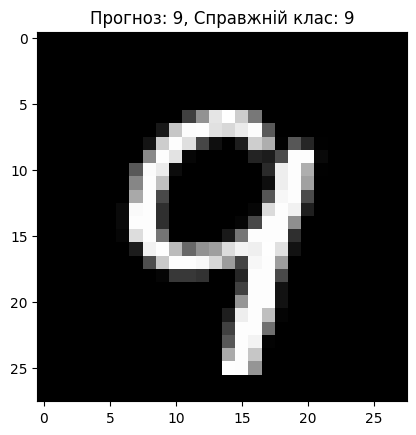

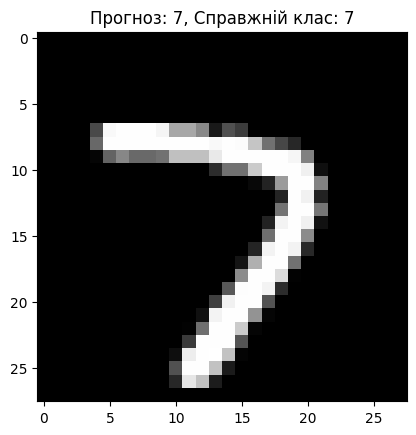

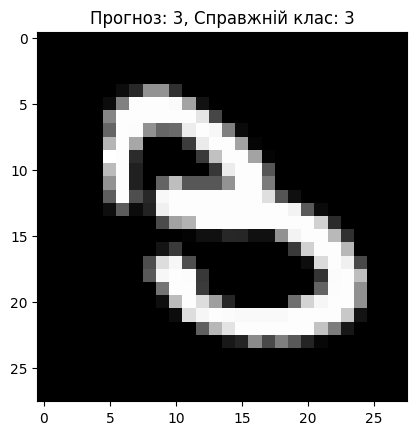

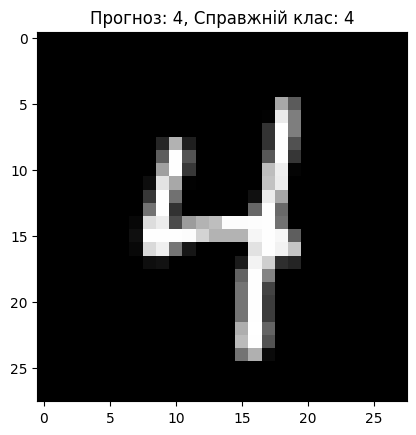

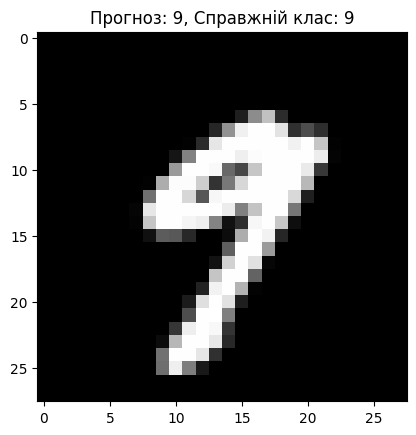

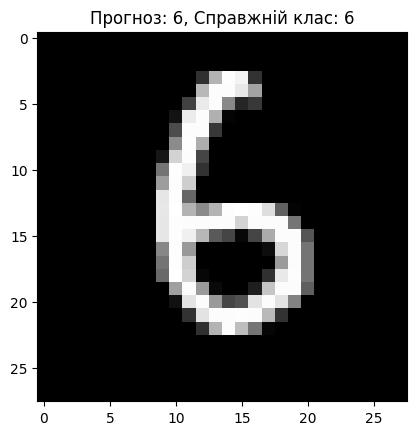

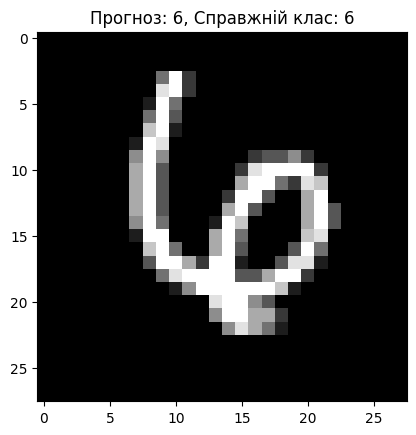

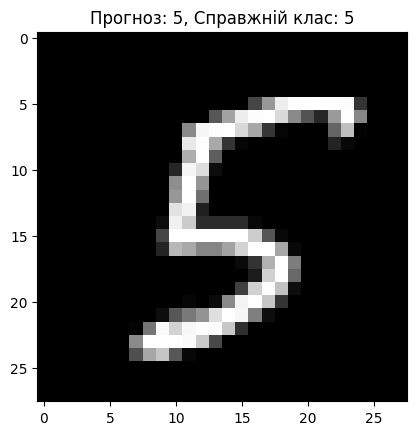

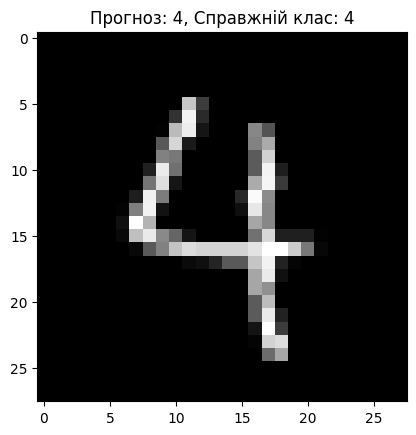

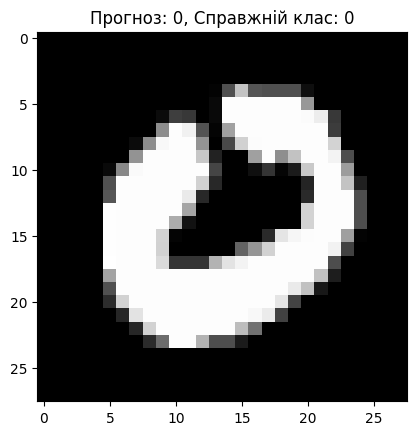

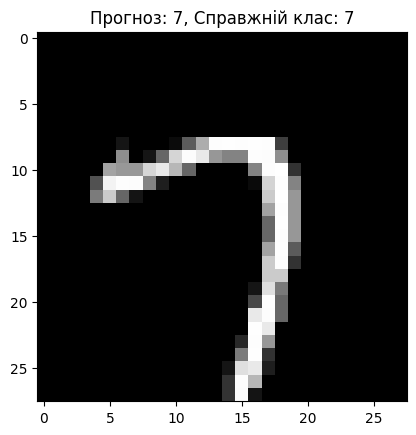

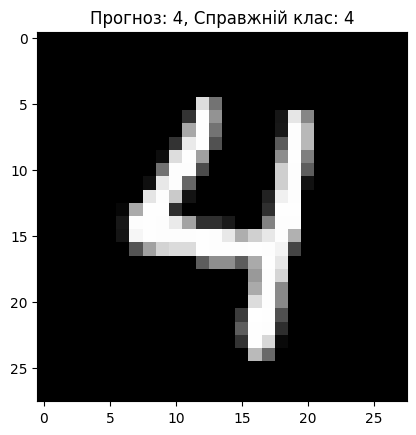

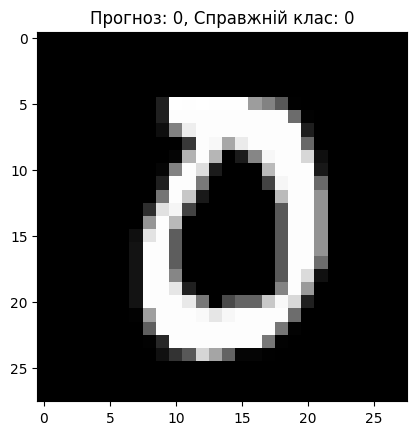

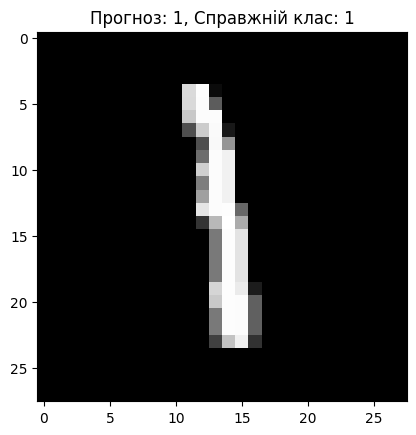

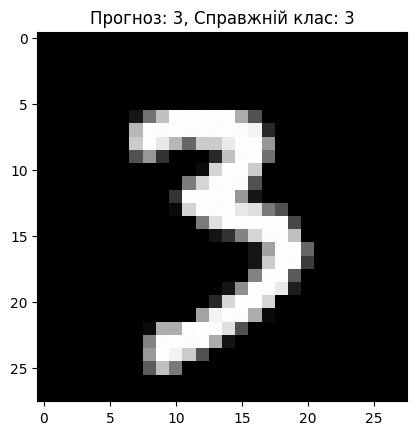

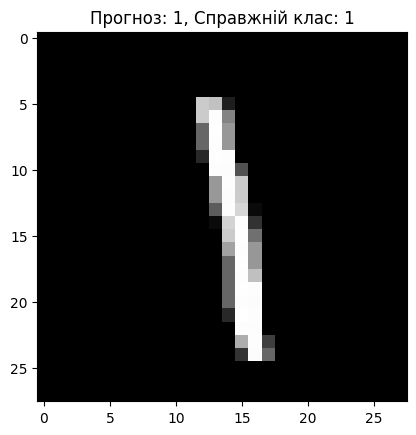

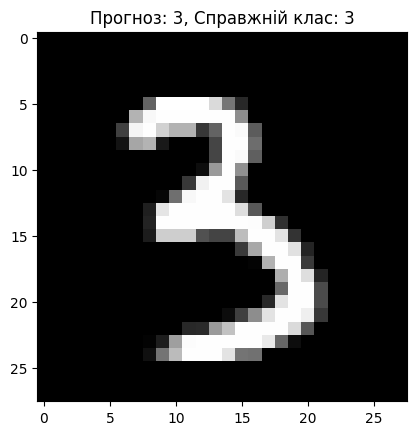

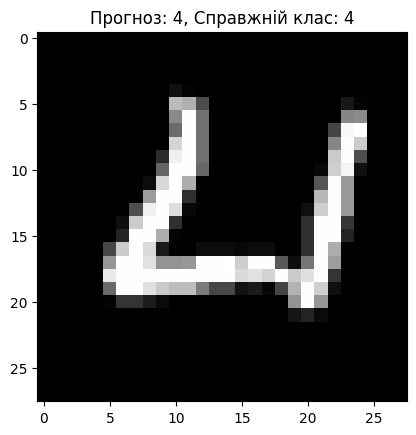

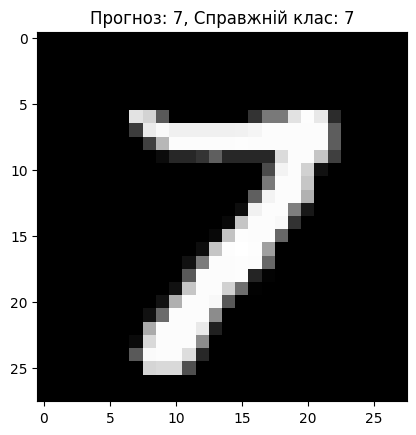

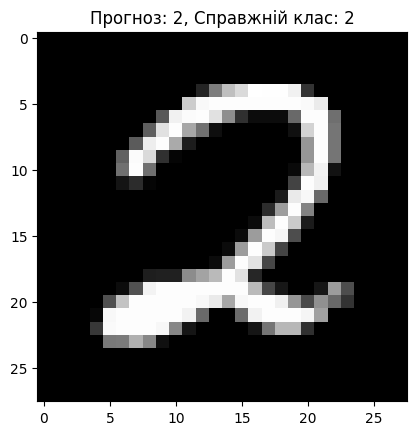

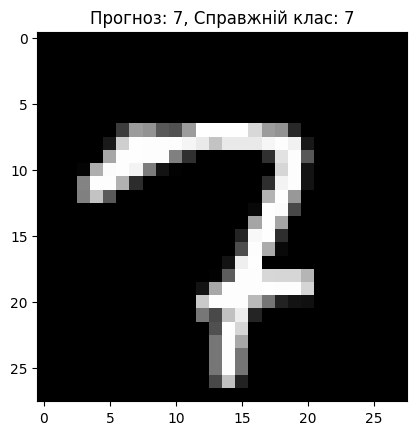

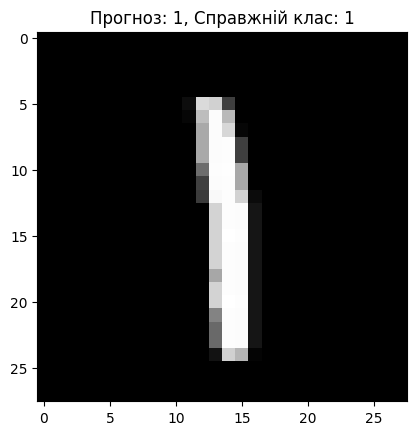

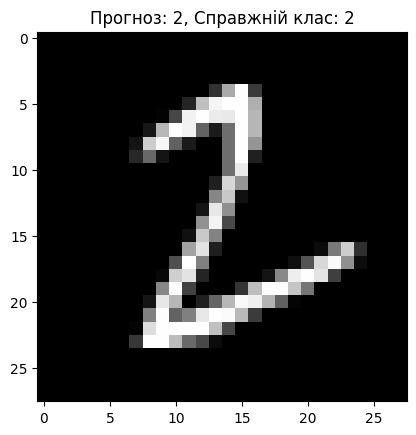

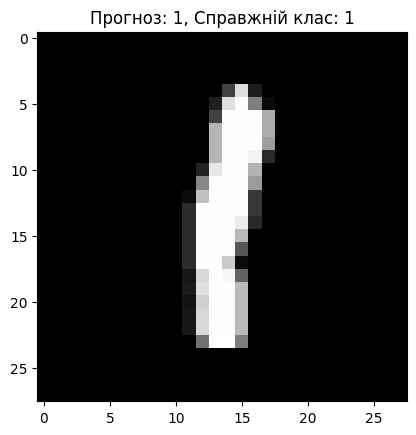

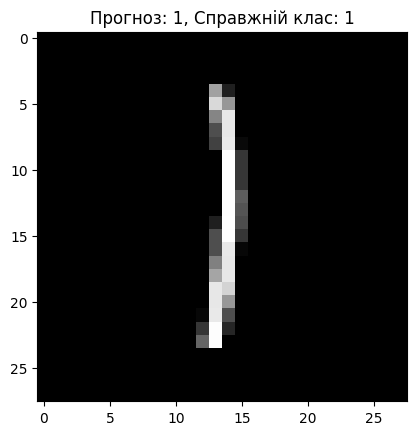

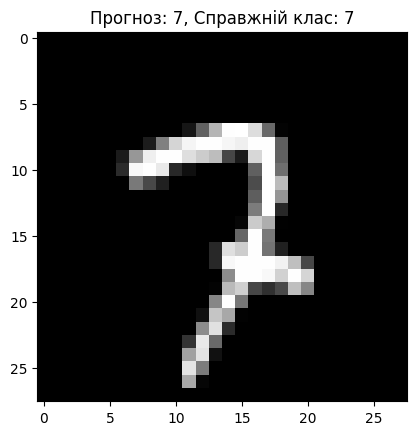

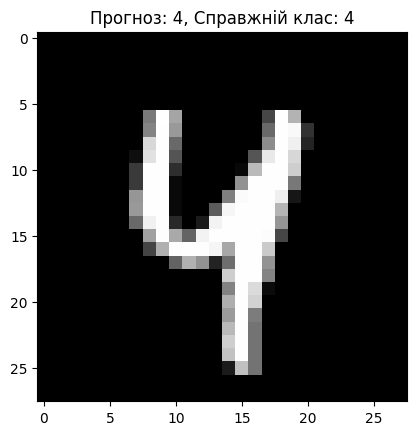

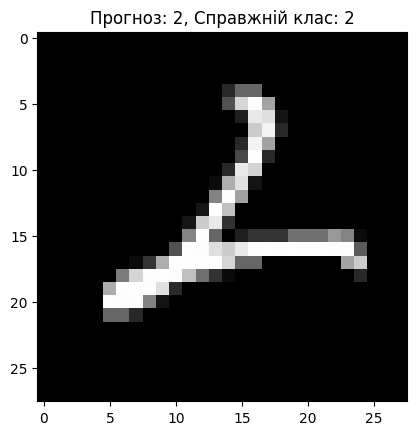

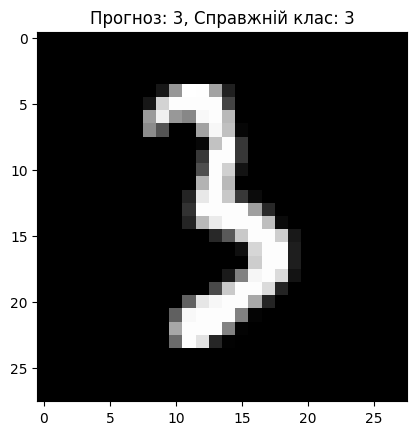

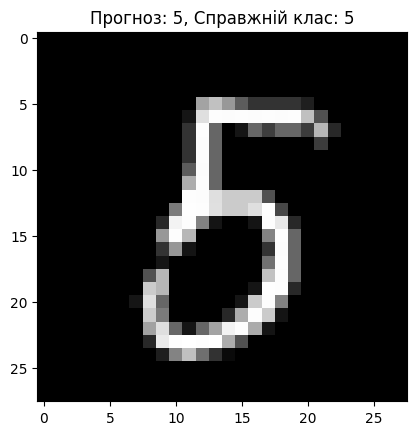

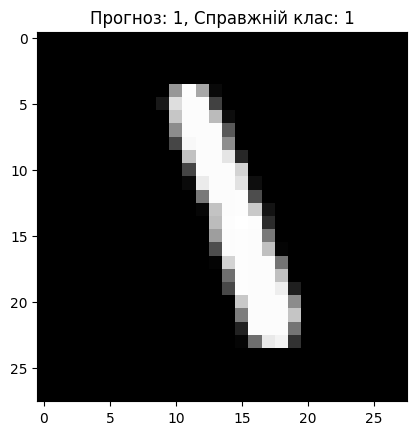

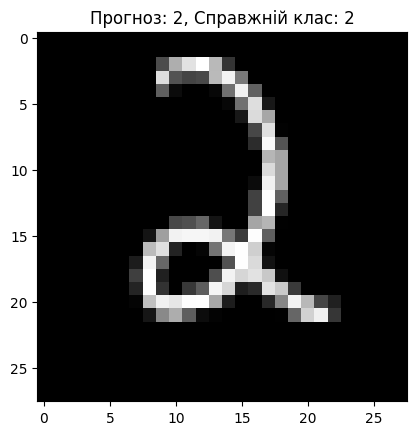

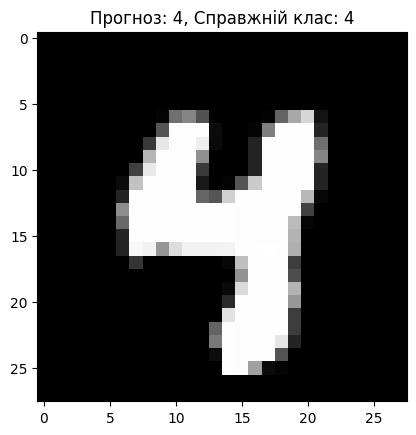

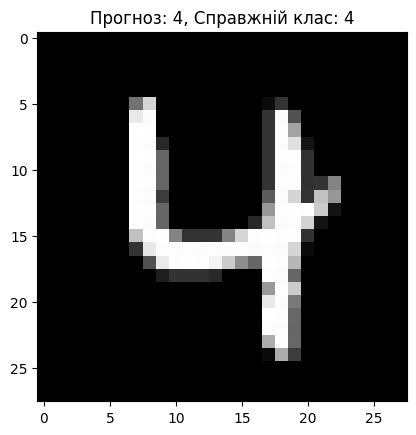

Отримана точність на 50 зразках: 0.96
нейромережа помилилася 2 разів з 50


In [67]:
# Протестуємо навчену нейромережу на 10 зображеннях. Із тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа і якщо так, то як часто?

test_samples = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(50)
acc = []
# Проходимо по кожному елементу
for test_x, test_y in test_samples:
    # Отримуємо прогноз від нейронної мережі
    prediction = neural_net(tf.expand_dims(test_x, axis=0))

    # Отримуємо прогнозований клас (індекс з максимальною ймовірністю)
    predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
    acc.append(predicted_class == test_y.numpy())
    # Виводимо зображення та прогнозований клас
    plt.imshow(test_x.numpy().reshape(28, 28), cmap="gray")
    plt.title(f"Прогноз: {predicted_class}, Справжній клас: {test_y.numpy()}")
    plt.show()

print(f"Отримана точність на 50 зразках: {sum(acc)/len(acc)}")
print(f"нейромережа помилилася {acc.count(0)} разів з 50")